In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

import time
import os
import cv2

img_height = 64
img_width = 64
batch_size = 32

In [2]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 5064 files belonging to 2 classes.


In [3]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 967 files belonging to 2 classes.


In [4]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [5]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 114216 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


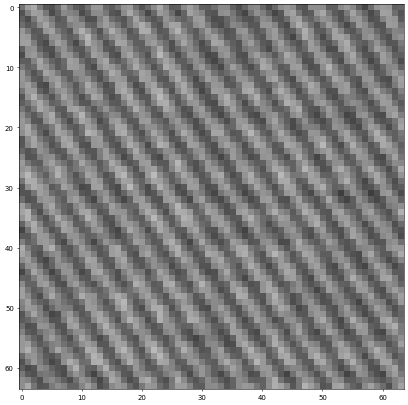

tf.Tensor(
[[[115. 115. 115.]
  [157. 157. 157.]
  [171. 171. 171.]
  ...
  [152. 152. 152.]
  [ 97.  97.  97.]
  [101. 101. 101.]]

 [[ 82.  82.  82.]
  [127. 127. 127.]
  [160. 160. 160.]
  ...
  [159. 159. 159.]
  [111. 111. 111.]
  [ 84.  84.  84.]]

 [[ 96.  96.  96.]
  [ 76.  76.  76.]
  [120. 120. 120.]
  ...
  [154. 154. 154.]
  [149. 149. 149.]
  [ 91.  91.  91.]]

 ...

 [[120. 120. 120.]
  [ 89.  89.  89.]
  [ 80.  80.  80.]
  ...
  [133. 133. 133.]
  [157. 157. 157.]
  [122. 122. 122.]]

 [[141. 141. 141.]
  [131. 131. 131.]
  [ 99.  99.  99.]
  ...
  [103. 103. 103.]
  [130. 130. 130.]
  [146. 146. 146.]]

 [[142. 142. 142.]
  [169. 169. 169.]
  [117. 117. 117.]
  ...
  [ 80.  80.  80.]
  [128. 128. 128.]
  [162. 162. 162.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


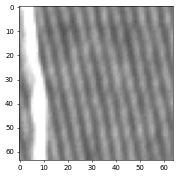

tf.Tensor(
[[[215. 215. 215.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [147. 147. 147.]
  [123. 123. 123.]
  [118. 118. 118.]]

 [[205. 205. 205.]
  [239. 239. 239.]
  [255. 255. 255.]
  ...
  [150. 150. 150.]
  [133. 133. 133.]
  [111. 111. 111.]]

 [[189. 189. 189.]
  [212. 212. 212.]
  [255. 255. 255.]
  ...
  [153. 153. 153.]
  [136. 136. 136.]
  [117. 117. 117.]]

 ...

 [[144. 144. 144.]
  [122. 122. 122.]
  [116. 116. 116.]
  ...
  [132. 132. 132.]
  [140. 140. 140.]
  [121. 121. 121.]]

 [[154. 154. 154.]
  [126. 126. 126.]
  [108. 108. 108.]
  ...
  [130. 130. 130.]
  [132. 132. 132.]
  [125. 125. 125.]]

 [[152. 152. 152.]
  [133. 133. 133.]
  [116. 116. 116.]
  ...
  [129. 129. 129.]
  [133. 133. 133.]
  [134. 134. 134.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


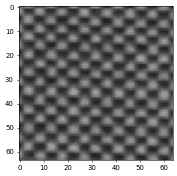

tf.Tensor(
[[[106. 106. 106.]
  [102. 102. 102.]
  [124. 124. 124.]
  ...
  [134. 134. 134.]
  [ 75.  75.  75.]
  [ 47.  47.  47.]]

 [[152. 152. 152.]
  [104. 104. 104.]
  [ 61.  61.  61.]
  ...
  [106. 106. 106.]
  [ 90.  90.  90.]
  [ 83.  83.  83.]]

 [[147. 147. 147.]
  [110. 110. 110.]
  [ 71.  71.  71.]
  ...
  [ 53.  53.  53.]
  [ 70.  70.  70.]
  [ 96.  96.  96.]]

 ...

 [[148. 148. 148.]
  [112. 112. 112.]
  [ 70.  70.  70.]
  ...
  [117. 117. 117.]
  [ 92.  92.  92.]
  [ 80.  80.  80.]]

 [[131. 131. 131.]
  [101. 101. 101.]
  [ 70.  70.  70.]
  ...
  [ 59.  59.  59.]
  [ 77.  77.  77.]
  [ 99.  99.  99.]]

 [[ 99.  99.  99.]
  [ 84.  84.  84.]
  [ 78.  78.  78.]
  ...
  [ 36.  36.  36.]
  [ 71.  71.  71.]
  [116. 116. 116.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


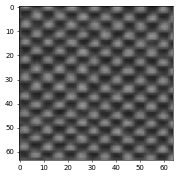

tf.Tensor(
[[[ 91.  91.  91.]
  [120. 120. 120.]
  [138. 138. 138.]
  ...
  [ 95.  95.  95.]
  [ 59.  59.  59.]
  [ 43.  43.  43.]]

 [[ 72.  72.  72.]
  [ 81.  81.  81.]
  [ 82.  82.  82.]
  ...
  [108. 108. 108.]
  [ 74.  74.  74.]
  [ 49.  49.  49.]]

 [[ 59.  59.  59.]
  [ 40.  40.  40.]
  [ 37.  37.  37.]
  ...
  [ 96.  96.  96.]
  [ 70.  70.  70.]
  [ 70.  70.  70.]]

 ...

 [[ 54.  54.  54.]
  [ 44.  44.  44.]
  [ 41.  41.  41.]
  ...
  [ 59.  59.  59.]
  [ 71.  71.  71.]
  [ 89.  89.  89.]]

 [[ 63.  63.  63.]
  [ 58.  58.  58.]
  [ 54.  54.  54.]
  ...
  [ 60.  60.  60.]
  [ 99.  99.  99.]
  [123. 123. 123.]]

 [[ 76.  76.  76.]
  [ 83.  83.  83.]
  [ 81.  81.  81.]
  ...
  [ 74.  74.  74.]
  [111. 111. 111.]
  [135. 135. 135.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


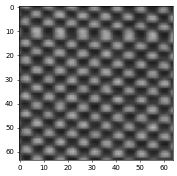

tf.Tensor(
[[[ 88.  88.  88.]
  [119. 119. 119.]
  [136. 136. 136.]
  ...
  [ 98.  98.  98.]
  [ 59.  59.  59.]
  [ 44.  44.  44.]]

 [[ 56.  56.  56.]
  [ 54.  54.  54.]
  [ 65.  65.  65.]
  ...
  [115. 115. 115.]
  [ 67.  67.  67.]
  [ 40.  40.  40.]]

 [[ 64.  64.  64.]
  [ 42.  42.  42.]
  [ 41.  41.  41.]
  ...
  [103. 103. 103.]
  [ 79.  79.  79.]
  [ 57.  57.  57.]]

 ...

 [[ 75.  75.  75.]
  [ 72.  72.  72.]
  [ 67.  67.  67.]
  ...
  [160. 160. 160.]
  [121. 121. 121.]
  [ 67.  67.  67.]]

 [[ 83.  83.  83.]
  [ 52.  52.  52.]
  [ 34.  34.  34.]
  ...
  [134. 134. 134.]
  [112. 112. 112.]
  [ 66.  66.  66.]]

 [[ 88.  88.  88.]
  [ 53.  53.  53.]
  [ 37.  37.  37.]
  ...
  [ 65.  65.  65.]
  [ 61.  61.  61.]
  [ 63.  63.  63.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


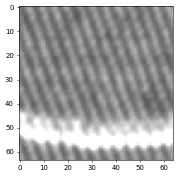

tf.Tensor(
[[[117. 117. 117.]
  [107. 107. 107.]
  [134. 134. 134.]
  ...
  [165. 165. 165.]
  [175. 175. 175.]
  [145. 145. 145.]]

 [[130. 130. 130.]
  [107. 107. 107.]
  [123. 123. 123.]
  ...
  [158. 158. 158.]
  [169. 169. 169.]
  [166. 166. 166.]]

 [[126. 126. 126.]
  [ 99.  99.  99.]
  [109. 109. 109.]
  ...
  [133. 133. 133.]
  [164. 164. 164.]
  [168. 168. 168.]]

 ...

 [[161. 161. 161.]
  [138. 138. 138.]
  [109. 109. 109.]
  ...
  [118. 118. 118.]
  [145. 145. 145.]
  [158. 158. 158.]]

 [[158. 158. 158.]
  [155. 155. 155.]
  [116. 116. 116.]
  ...
  [118. 118. 118.]
  [134. 134. 134.]
  [161. 161. 161.]]

 [[158. 158. 158.]
  [163. 163. 163.]
  [128. 128. 128.]
  ...
  [119. 119. 119.]
  [129. 129. 129.]
  [148. 148. 148.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


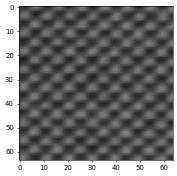

tf.Tensor(
[[[ 61.  61.  61.]
  [ 51.  51.  51.]
  [ 43.  43.  43.]
  ...
  [ 60.  60.  60.]
  [ 91.  91.  91.]
  [117. 117. 117.]]

 [[ 67.  67.  67.]
  [ 60.  60.  60.]
  [ 66.  66.  66.]
  ...
  [ 86.  86.  86.]
  [104. 104. 104.]
  [123. 123. 123.]]

 [[ 70.  70.  70.]
  [ 92.  92.  92.]
  [ 99.  99.  99.]
  ...
  [ 88.  88.  88.]
  [ 91.  91.  91.]
  [ 88.  88.  88.]]

 ...

 [[ 86.  86.  86.]
  [ 94.  94.  94.]
  [ 95.  95.  95.]
  ...
  [ 93.  93.  93.]
  [ 96.  96.  96.]
  [102. 102. 102.]]

 [[101. 101. 101.]
  [115. 115. 115.]
  [107. 107. 107.]
  ...
  [ 80.  80.  80.]
  [ 59.  59.  59.]
  [ 50.  50.  50.]]

 [[108. 108. 108.]
  [120. 120. 120.]
  [112. 112. 112.]
  ...
  [ 85.  85.  85.]
  [ 54.  54.  54.]
  [ 44.  44.  44.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


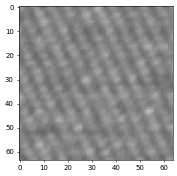

tf.Tensor(
[[[155. 155. 155.]
  [152. 152. 152.]
  [133. 133. 133.]
  ...
  [126. 126. 126.]
  [129. 129. 129.]
  [157. 157. 157.]]

 [[146. 146. 146.]
  [142. 142. 142.]
  [131. 131. 131.]
  ...
  [128. 128. 128.]
  [126. 126. 126.]
  [136. 136. 136.]]

 [[126. 126. 126.]
  [126. 126. 126.]
  [127. 127. 127.]
  ...
  [138. 138. 138.]
  [128. 128. 128.]
  [132. 132. 132.]]

 ...

 [[118. 118. 118.]
  [118. 118. 118.]
  [134. 134. 134.]
  ...
  [132. 132. 132.]
  [131. 131. 131.]
  [124. 124. 124.]]

 [[111. 111. 111.]
  [107. 107. 107.]
  [117. 117. 117.]
  ...
  [134. 134. 134.]
  [134. 134. 134.]
  [132. 132. 132.]]

 [[126. 126. 126.]
  [111. 111. 111.]
  [103. 103. 103.]
  ...
  [138. 138. 138.]
  [152. 152. 152.]
  [151. 151. 151.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


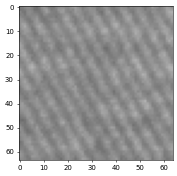

tf.Tensor(
[[[124. 124. 124.]
  [126. 126. 126.]
  [136. 136. 136.]
  ...
  [161. 161. 161.]
  [156. 156. 156.]
  [144. 144. 144.]]

 [[117. 117. 117.]
  [120. 120. 120.]
  [126. 126. 126.]
  ...
  [162. 162. 162.]
  [163. 163. 163.]
  [158. 158. 158.]]

 [[136. 136. 136.]
  [121. 121. 121.]
  [117. 117. 117.]
  ...
  [160. 160. 160.]
  [172. 172. 172.]
  [176. 176. 176.]]

 ...

 [[153. 153. 153.]
  [144. 144. 144.]
  [133. 133. 133.]
  ...
  [127. 127. 127.]
  [136. 136. 136.]
  [148. 148. 148.]]

 [[150. 150. 150.]
  [144. 144. 144.]
  [131. 131. 131.]
  ...
  [125. 125. 125.]
  [132. 132. 132.]
  [136. 136. 136.]]

 [[141. 141. 141.]
  [139. 139. 139.]
  [134. 134. 134.]
  ...
  [118. 118. 118.]
  [122. 122. 122.]
  [133. 133. 133.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


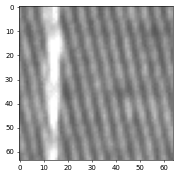

tf.Tensor(
[[[140. 140. 140.]
  [114. 114. 114.]
  [114. 114. 114.]
  ...
  [133. 133. 133.]
  [155. 155. 155.]
  [151. 151. 151.]]

 [[149. 149. 149.]
  [114. 114. 114.]
  [117. 117. 117.]
  ...
  [138. 138. 138.]
  [165. 165. 165.]
  [151. 151. 151.]]

 [[151. 151. 151.]
  [115. 115. 115.]
  [115. 115. 115.]
  ...
  [139. 139. 139.]
  [175. 175. 175.]
  [162. 162. 162.]]

 ...

 [[119. 119. 119.]
  [133. 133. 133.]
  [140. 140. 140.]
  ...
  [115. 115. 115.]
  [103. 103. 103.]
  [113. 113. 113.]]

 [[115. 115. 115.]
  [138. 138. 138.]
  [153. 153. 153.]
  ...
  [129. 129. 129.]
  [103. 103. 103.]
  [113. 113. 113.]]

 [[108. 108. 108.]
  [137. 137. 137.]
  [156. 156. 156.]
  ...
  [136. 136. 136.]
  [111. 111. 111.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


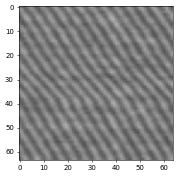

tf.Tensor(
[[[132. 132. 132.]
  [105. 105. 105.]
  [ 95.  95.  95.]
  ...
  [151. 151. 151.]
  [117. 117. 117.]
  [ 90.  90.  90.]]

 [[153. 153. 153.]
  [142. 142. 142.]
  [101. 101. 101.]
  ...
  [158. 158. 158.]
  [135. 135. 135.]
  [106. 106. 106.]]

 [[133. 133. 133.]
  [143. 143. 143.]
  [126. 126. 126.]
  ...
  [140. 140. 140.]
  [154. 154. 154.]
  [128. 128. 128.]]

 ...

 [[120. 120. 120.]
  [136. 136. 136.]
  [121. 121. 121.]
  ...
  [129. 129. 129.]
  [146. 146. 146.]
  [127. 127. 127.]]

 [[111. 111. 111.]
  [145. 145. 145.]
  [144. 144. 144.]
  ...
  [117. 117. 117.]
  [143. 143. 143.]
  [146. 146. 146.]]

 [[ 99.  99.  99.]
  [131. 131. 131.]
  [156. 156. 156.]
  ...
  [114. 114. 114.]
  [138. 138. 138.]
  [157. 157. 157.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


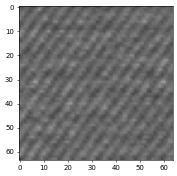

tf.Tensor(
[[[ 81.  81.  81.]
  [ 79.  79.  79.]
  [ 98.  98.  98.]
  ...
  [103. 103. 103.]
  [ 98.  98.  98.]
  [102. 102. 102.]]

 [[ 96.  96.  96.]
  [100. 100. 100.]
  [104. 104. 104.]
  ...
  [107. 107. 107.]
  [ 98.  98.  98.]
  [ 94.  94.  94.]]

 [[103. 103. 103.]
  [119. 119. 119.]
  [102. 102. 102.]
  ...
  [106. 106. 106.]
  [101. 101. 101.]
  [ 98.  98.  98.]]

 ...

 [[151. 151. 151.]
  [116. 116. 116.]
  [ 96.  96.  96.]
  ...
  [105. 105. 105.]
  [123. 123. 123.]
  [126. 126. 126.]]

 [[111. 111. 111.]
  [ 97.  97.  97.]
  [ 90.  90.  90.]
  ...
  [ 97.  97.  97.]
  [112. 112. 112.]
  [ 96.  96.  96.]]

 [[ 67.  67.  67.]
  [ 82.  82.  82.]
  [102. 102. 102.]
  ...
  [110. 110. 110.]
  [118. 118. 118.]
  [103. 103. 103.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


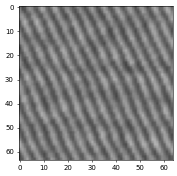

tf.Tensor(
[[[115. 115. 115.]
  [ 75.  75.  75.]
  [ 89.  89.  89.]
  ...
  [169. 169. 169.]
  [143. 143. 143.]
  [103. 103. 103.]]

 [[126. 126. 126.]
  [ 81.  81.  81.]
  [ 80.  80.  80.]
  ...
  [174. 174. 174.]
  [161. 161. 161.]
  [116. 116. 116.]]

 [[131. 131. 131.]
  [110. 110. 110.]
  [ 83.  83.  83.]
  ...
  [158. 158. 158.]
  [168. 168. 168.]
  [135. 135. 135.]]

 ...

 [[ 87.  87.  87.]
  [132. 132. 132.]
  [154. 154. 154.]
  ...
  [ 87.  87.  87.]
  [ 91.  91.  91.]
  [131. 131. 131.]]

 [[ 76.  76.  76.]
  [108. 108. 108.]
  [147. 147. 147.]
  ...
  [102. 102. 102.]
  [ 78.  78.  78.]
  [ 96.  96.  96.]]

 [[ 79.  79.  79.]
  [ 91.  91.  91.]
  [137. 137. 137.]
  ...
  [116. 116. 116.]
  [ 82.  82.  82.]
  [ 91.  91.  91.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


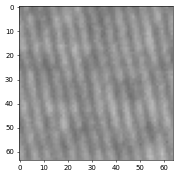

tf.Tensor(
[[[130. 130. 130.]
  [131. 131. 131.]
  [149. 149. 149.]
  ...
  [148. 148. 148.]
  [128. 128. 128.]
  [132. 132. 132.]]

 [[136. 136. 136.]
  [130. 130. 130.]
  [147. 147. 147.]
  ...
  [136. 136. 136.]
  [139. 139. 139.]
  [134. 134. 134.]]

 [[137. 137. 137.]
  [128. 128. 128.]
  [137. 137. 137.]
  ...
  [143. 143. 143.]
  [141. 141. 141.]
  [144. 144. 144.]]

 ...

 [[165. 165. 165.]
  [166. 166. 166.]
  [140. 140. 140.]
  ...
  [153. 153. 153.]
  [135. 135. 135.]
  [156. 156. 156.]]

 [[164. 164. 164.]
  [159. 159. 159.]
  [142. 142. 142.]
  ...
  [154. 154. 154.]
  [142. 142. 142.]
  [145. 145. 145.]]

 [[156. 156. 156.]
  [161. 161. 161.]
  [145. 145. 145.]
  ...
  [159. 159. 159.]
  [142. 142. 142.]
  [145. 145. 145.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


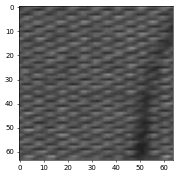

tf.Tensor(
[[[ 62.  62.  62.]
  [ 73.  73.  73.]
  [ 85.  85.  85.]
  ...
  [122. 122. 122.]
  [120. 120. 120.]
  [ 94.  94.  94.]]

 [[ 65.  65.  65.]
  [ 81.  81.  81.]
  [ 94.  94.  94.]
  ...
  [ 90.  90.  90.]
  [ 66.  66.  66.]
  [ 54.  54.  54.]]

 [[ 92.  92.  92.]
  [ 89.  89.  89.]
  [ 80.  80.  80.]
  ...
  [ 69.  69.  69.]
  [ 71.  71.  71.]
  [ 80.  80.  80.]]

 ...

 [[ 78.  78.  78.]
  [ 65.  65.  65.]
  [ 68.  68.  68.]
  ...
  [ 74.  74.  74.]
  [ 70.  70.  70.]
  [ 79.  79.  79.]]

 [[ 72.  72.  72.]
  [ 82.  82.  82.]
  [108. 108. 108.]
  ...
  [148. 148. 148.]
  [135. 135. 135.]
  [100. 100. 100.]]

 [[ 78.  78.  78.]
  [ 88.  88.  88.]
  [ 99.  99.  99.]
  ...
  [ 99.  99.  99.]
  [ 84.  84.  84.]
  [ 77.  77.  77.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


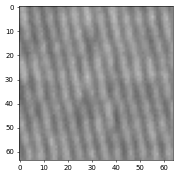

tf.Tensor(
[[[160. 160. 160.]
  [174. 174. 174.]
  [161. 161. 161.]
  ...
  [138. 138. 138.]
  [120. 120. 120.]
  [134. 134. 134.]]

 [[159. 159. 159.]
  [175. 175. 175.]
  [162. 162. 162.]
  ...
  [144. 144. 144.]
  [119. 119. 119.]
  [132. 132. 132.]]

 [[149. 149. 149.]
  [166. 166. 166.]
  [163. 163. 163.]
  ...
  [153. 153. 153.]
  [131. 131. 131.]
  [131. 131. 131.]]

 ...

 [[127. 127. 127.]
  [113. 113. 113.]
  [128. 128. 128.]
  ...
  [163. 163. 163.]
  [172. 172. 172.]
  [152. 152. 152.]]

 [[126. 126. 126.]
  [117. 117. 117.]
  [129. 129. 129.]
  ...
  [149. 149. 149.]
  [158. 158. 158.]
  [152. 152. 152.]]

 [[135. 135. 135.]
  [123. 123. 123.]
  [124. 124. 124.]
  ...
  [143. 143. 143.]
  [160. 160. 160.]
  [148. 148. 148.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


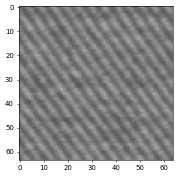

tf.Tensor(
[[[107. 107. 107.]
  [ 99.  99.  99.]
  [117. 117. 117.]
  ...
  [158. 158. 158.]
  [141. 141. 141.]
  [115. 115. 115.]]

 [[127. 127. 127.]
  [ 97.  97.  97.]
  [ 92.  92.  92.]
  ...
  [128. 128. 128.]
  [154. 154. 154.]
  [136. 136. 136.]]

 [[129. 129. 129.]
  [109. 109. 109.]
  [ 95.  95.  95.]
  ...
  [114. 114. 114.]
  [138. 138. 138.]
  [136. 136. 136.]]

 ...

 [[122. 122. 122.]
  [132. 132. 132.]
  [117. 117. 117.]
  ...
  [104. 104. 104.]
  [102. 102. 102.]
  [125. 125. 125.]]

 [[101. 101. 101.]
  [136. 136. 136.]
  [155. 155. 155.]
  ...
  [130. 130. 130.]
  [105. 105. 105.]
  [103. 103. 103.]]

 [[ 95.  95.  95.]
  [123. 123. 123.]
  [144. 144. 144.]
  ...
  [134. 134. 134.]
  [114. 114. 114.]
  [ 98.  98.  98.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


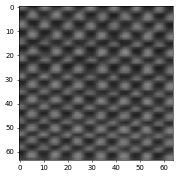

tf.Tensor(
[[[116. 116. 116.]
  [123. 123. 123.]
  [108. 108. 108.]
  ...
  [ 45.  45.  45.]
  [ 36.  36.  36.]
  [ 35.  35.  35.]]

 [[ 85.  85.  85.]
  [ 86.  86.  86.]
  [ 79.  79.  79.]
  ...
  [ 51.  51.  51.]
  [ 41.  41.  41.]
  [ 42.  42.  42.]]

 [[ 39.  39.  39.]
  [ 36.  36.  36.]
  [ 42.  42.  42.]
  ...
  [ 52.  52.  52.]
  [ 56.  56.  56.]
  [ 61.  61.  61.]]

 ...

 [[ 36.  36.  36.]
  [ 39.  39.  39.]
  [ 57.  57.  57.]
  ...
  [ 67.  67.  67.]
  [ 81.  81.  81.]
  [ 88.  88.  88.]]

 [[ 54.  54.  54.]
  [ 53.  53.  53.]
  [ 67.  67.  67.]
  ...
  [111. 111. 111.]
  [121. 121. 121.]
  [120. 120. 120.]]

 [[ 69.  69.  69.]
  [ 62.  62.  62.]
  [ 65.  65.  65.]
  ...
  [109. 109. 109.]
  [123. 123. 123.]
  [118. 118. 118.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


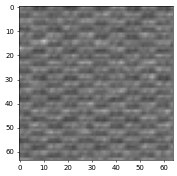

tf.Tensor(
[[[140. 140. 140.]
  [129. 129. 129.]
  [113. 113. 113.]
  ...
  [ 81.  81.  81.]
  [ 92.  92.  92.]
  [120. 120. 120.]]

 [[123. 123. 123.]
  [107. 107. 107.]
  [108. 108. 108.]
  ...
  [ 73.  73.  73.]
  [ 80.  80.  80.]
  [ 97.  97.  97.]]

 [[121. 121. 121.]
  [124. 124. 124.]
  [124. 124. 124.]
  ...
  [102. 102. 102.]
  [116. 116. 116.]
  [122. 122. 122.]]

 ...

 [[ 96.  96.  96.]
  [101. 101. 101.]
  [ 93.  93.  93.]
  ...
  [131. 131. 131.]
  [131. 131. 131.]
  [112. 112. 112.]]

 [[102. 102. 102.]
  [102. 102. 102.]
  [ 89.  89.  89.]
  ...
  [115. 115. 115.]
  [119. 119. 119.]
  [111. 111. 111.]]

 [[142. 142. 142.]
  [139. 139. 139.]
  [141. 141. 141.]
  ...
  [117. 117. 117.]
  [124. 124. 124.]
  [125. 125. 125.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


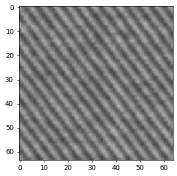

tf.Tensor(
[[[151. 151. 151.]
  [121. 121. 121.]
  [106. 106. 106.]
  ...
  [105. 105. 105.]
  [165. 165. 165.]
  [154. 154. 154.]]

 [[155. 155. 155.]
  [130. 130. 130.]
  [101. 101. 101.]
  ...
  [ 97.  97.  97.]
  [124. 124. 124.]
  [153. 153. 153.]]

 [[131. 131. 131.]
  [137. 137. 137.]
  [119. 119. 119.]
  ...
  [ 92.  92.  92.]
  [ 83.  83.  83.]
  [138. 138. 138.]]

 ...

 [[109. 109. 109.]
  [ 93.  93.  93.]
  [102. 102. 102.]
  ...
  [144. 144. 144.]
  [149. 149. 149.]
  [123. 123. 123.]]

 [[148. 148. 148.]
  [115. 115. 115.]
  [ 82.  82.  82.]
  ...
  [ 89.  89.  89.]
  [148. 148. 148.]
  [148. 148. 148.]]

 [[149. 149. 149.]
  [128. 128. 128.]
  [ 97.  97.  97.]
  ...
  [ 84.  84.  84.]
  [116. 116. 116.]
  [137. 137. 137.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


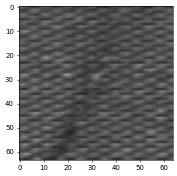

tf.Tensor(
[[[ 94.  94.  94.]
  [ 95.  95.  95.]
  [ 85.  85.  85.]
  ...
  [ 61.  61.  61.]
  [ 61.  61.  61.]
  [ 60.  60.  60.]]

 [[ 72.  72.  72.]
  [ 69.  69.  69.]
  [ 64.  64.  64.]
  ...
  [ 91.  91.  91.]
  [104. 104. 104.]
  [ 96.  96.  96.]]

 [[ 68.  68.  68.]
  [ 63.  63.  63.]
  [ 66.  66.  66.]
  ...
  [ 84.  84.  84.]
  [ 98.  98.  98.]
  [ 98.  98.  98.]]

 ...

 [[ 90.  90.  90.]
  [118. 118. 118.]
  [138. 138. 138.]
  ...
  [106. 106. 106.]
  [ 79.  79.  79.]
  [ 71.  71.  71.]]

 [[ 98.  98.  98.]
  [102. 102. 102.]
  [100. 100. 100.]
  ...
  [ 74.  74.  74.]
  [ 63.  63.  63.]
  [ 68.  68.  68.]]

 [[ 66.  66.  66.]
  [ 55.  55.  55.]
  [ 49.  49.  49.]
  ...
  [ 62.  62.  62.]
  [ 77.  77.  77.]
  [ 91.  91.  91.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


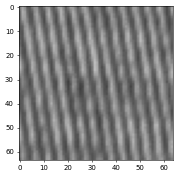

tf.Tensor(
[[[131. 131. 131.]
  [163. 163. 163.]
  [142. 142. 142.]
  ...
  [ 72.  72.  72.]
  [106. 106. 106.]
  [159. 159. 159.]]

 [[123. 123. 123.]
  [168. 168. 168.]
  [148. 148. 148.]
  ...
  [ 74.  74.  74.]
  [ 98.  98.  98.]
  [164. 164. 164.]]

 [[112. 112. 112.]
  [173. 173. 173.]
  [161. 161. 161.]
  ...
  [ 74.  74.  74.]
  [ 92.  92.  92.]
  [149. 149. 149.]]

 ...

 [[121. 121. 121.]
  [153. 153. 153.]
  [127. 127. 127.]
  ...
  [ 96.  96.  96.]
  [120. 120. 120.]
  [147. 147. 147.]]

 [[120. 120. 120.]
  [153. 153. 153.]
  [127. 127. 127.]
  ...
  [ 95.  95.  95.]
  [117. 117. 117.]
  [137. 137. 137.]]

 [[108. 108. 108.]
  [146. 146. 146.]
  [123. 123. 123.]
  ...
  [ 96.  96.  96.]
  [102. 102. 102.]
  [124. 124. 124.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


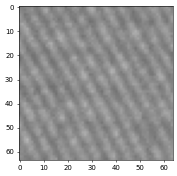

tf.Tensor(
[[[128. 128. 128.]
  [127. 127. 127.]
  [134. 134. 134.]
  ...
  [154. 154. 154.]
  [142. 142. 142.]
  [129. 129. 129.]]

 [[134. 134. 134.]
  [129. 129. 129.]
  [125. 125. 125.]
  ...
  [146. 146. 146.]
  [155. 155. 155.]
  [134. 134. 134.]]

 [[139. 139. 139.]
  [133. 133. 133.]
  [131. 131. 131.]
  ...
  [146. 146. 146.]
  [144. 144. 144.]
  [136. 136. 136.]]

 ...

 [[137. 137. 137.]
  [135. 135. 135.]
  [136. 136. 136.]
  ...
  [136. 136. 136.]
  [141. 141. 141.]
  [152. 152. 152.]]

 [[146. 146. 146.]
  [141. 141. 141.]
  [125. 125. 125.]
  ...
  [130. 130. 130.]
  [143. 143. 143.]
  [159. 159. 159.]]

 [[138. 138. 138.]
  [136. 136. 136.]
  [130. 130. 130.]
  ...
  [131. 131. 131.]
  [139. 139. 139.]
  [148. 148. 148.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


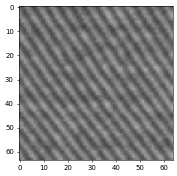

tf.Tensor(
[[[ 96.  96.  96.]
  [ 81.  81.  81.]
  [116. 116. 116.]
  ...
  [138. 138. 138.]
  [112. 112. 112.]
  [ 80.  80.  80.]]

 [[115. 115. 115.]
  [ 88.  88.  88.]
  [ 88.  88.  88.]
  ...
  [129. 129. 129.]
  [136. 136. 136.]
  [104. 104. 104.]]

 [[129. 129. 129.]
  [ 88.  88.  88.]
  [ 72.  72.  72.]
  ...
  [113. 113. 113.]
  [150. 150. 150.]
  [144. 144. 144.]]

 ...

 [[143. 143. 143.]
  [105. 105. 105.]
  [ 88.  88.  88.]
  ...
  [125. 125. 125.]
  [148. 148. 148.]
  [159. 159. 159.]]

 [[147. 147. 147.]
  [124. 124. 124.]
  [ 94.  94.  94.]
  ...
  [ 93.  93.  93.]
  [137. 137. 137.]
  [165. 165. 165.]]

 [[115. 115. 115.]
  [146. 146. 146.]
  [111. 111. 111.]
  ...
  [ 92.  92.  92.]
  [102. 102. 102.]
  [136. 136. 136.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


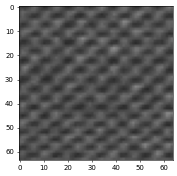

tf.Tensor(
[[[ 65.  65.  65.]
  [ 59.  59.  59.]
  [ 61.  61.  61.]
  ...
  [105. 105. 105.]
  [119. 119. 119.]
  [105. 105. 105.]]

 [[ 72.  72.  72.]
  [ 81.  81.  81.]
  [ 70.  70.  70.]
  ...
  [ 99.  99.  99.]
  [101. 101. 101.]
  [ 90.  90.  90.]]

 [[ 87.  87.  87.]
  [102. 102. 102.]
  [ 97.  97.  97.]
  ...
  [ 79.  79.  79.]
  [ 81.  81.  81.]
  [ 75.  75.  75.]]

 ...

 [[ 88.  88.  88.]
  [ 92.  92.  92.]
  [ 82.  82.  82.]
  ...
  [ 54.  54.  54.]
  [ 46.  46.  46.]
  [ 57.  57.  57.]]

 [[ 79.  79.  79.]
  [ 81.  81.  81.]
  [ 74.  74.  74.]
  ...
  [ 52.  52.  52.]
  [ 48.  48.  48.]
  [ 59.  59.  59.]]

 [[ 71.  71.  71.]
  [ 74.  74.  74.]
  [ 68.  68.  68.]
  ...
  [ 85.  85.  85.]
  [ 82.  82.  82.]
  [ 79.  79.  79.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


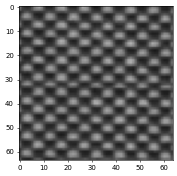

tf.Tensor(
[[[109. 109. 109.]
  [ 63.  63.  63.]
  [ 49.  49.  49.]
  ...
  [ 34.  34.  34.]
  [ 47.  47.  47.]
  [ 64.  64.  64.]]

 [[ 94.  94.  94.]
  [ 62.  62.  62.]
  [ 60.  60.  60.]
  ...
  [ 34.  34.  34.]
  [ 45.  45.  45.]
  [ 95.  95.  95.]]

 [[ 45.  45.  45.]
  [ 58.  58.  58.]
  [ 78.  78.  78.]
  ...
  [ 53.  53.  53.]
  [ 63.  63.  63.]
  [106. 106. 106.]]

 ...

 [[ 69.  69.  69.]
  [111. 111. 111.]
  [148. 148. 148.]
  ...
  [136. 136. 136.]
  [104. 104. 104.]
  [ 63.  63.  63.]]

 [[ 60.  60.  60.]
  [ 78.  78.  78.]
  [ 89.  89.  89.]
  ...
  [151. 151. 151.]
  [131. 131. 131.]
  [ 80.  80.  80.]]

 [[ 78.  78.  78.]
  [ 44.  44.  44.]
  [ 37.  37.  37.]
  ...
  [114. 114. 114.]
  [114. 114. 114.]
  [ 85.  85.  85.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


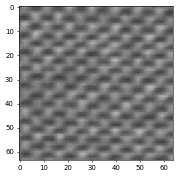

tf.Tensor(
[[[111. 111. 111.]
  [133. 133. 133.]
  [140. 140. 140.]
  ...
  [125. 125. 125.]
  [122. 122. 122.]
  [116. 116. 116.]]

 [[115. 115. 115.]
  [124. 124. 124.]
  [124. 124. 124.]
  ...
  [110. 110. 110.]
  [ 95.  95.  95.]
  [ 86.  86.  86.]]

 [[133. 133. 133.]
  [125. 125. 125.]
  [124. 124. 124.]
  ...
  [ 76.  76.  76.]
  [ 66.  66.  66.]
  [ 62.  62.  62.]]

 ...

 [[101. 101. 101.]
  [ 79.  79.  79.]
  [ 66.  66.  66.]
  ...
  [110. 110. 110.]
  [108. 108. 108.]
  [114. 114. 114.]]

 [[112. 112. 112.]
  [ 93.  93.  93.]
  [ 87.  87.  87.]
  ...
  [101. 101. 101.]
  [128. 128. 128.]
  [155. 155. 155.]]

 [[107. 107. 107.]
  [124. 124. 124.]
  [132. 132. 132.]
  ...
  [ 90.  90.  90.]
  [122. 122. 122.]
  [143. 143. 143.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


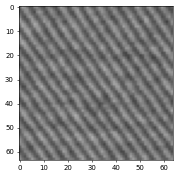

tf.Tensor(
[[[107. 107. 107.]
  [157. 157. 157.]
  [147. 147. 147.]
  ...
  [ 93.  93.  93.]
  [ 78.  78.  78.]
  [ 91.  91.  91.]]

 [[ 88.  88.  88.]
  [122. 122. 122.]
  [142. 142. 142.]
  ...
  [112. 112. 112.]
  [ 80.  80.  80.]
  [ 76.  76.  76.]]

 [[ 92.  92.  92.]
  [ 94.  94.  94.]
  [138. 138. 138.]
  ...
  [123. 123. 123.]
  [107. 107. 107.]
  [ 81.  81.  81.]]

 ...

 [[102. 102. 102.]
  [ 94.  94.  94.]
  [100. 100. 100.]
  ...
  [141. 141. 141.]
  [134. 134. 134.]
  [ 96.  96.  96.]]

 [[129. 129. 129.]
  [ 97.  97.  97.]
  [ 80.  80.  80.]
  ...
  [136. 136. 136.]
  [147. 147. 147.]
  [123. 123. 123.]]

 [[141. 141. 141.]
  [114. 114. 114.]
  [ 96.  96.  96.]
  ...
  [ 95.  95.  95.]
  [128. 128. 128.]
  [139. 139. 139.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


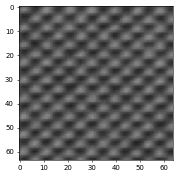

tf.Tensor(
[[[ 85.  85.  85.]
  [110. 110. 110.]
  [111. 111. 111.]
  ...
  [ 70.  70.  70.]
  [ 61.  61.  61.]
  [ 57.  57.  57.]]

 [[107. 107. 107.]
  [128. 128. 128.]
  [130. 130. 130.]
  ...
  [ 73.  73.  73.]
  [ 53.  53.  53.]
  [ 49.  49.  49.]]

 [[ 94.  94.  94.]
  [101. 101. 101.]
  [ 94.  94.  94.]
  ...
  [ 83.  83.  83.]
  [ 68.  68.  68.]
  [ 70.  70.  70.]]

 ...

 [[117. 117. 117.]
  [121. 121. 121.]
  [115. 115. 115.]
  ...
  [ 71.  71.  71.]
  [ 56.  56.  56.]
  [ 57.  57.  57.]]

 [[ 84.  84.  84.]
  [ 74.  74.  74.]
  [ 65.  65.  65.]
  ...
  [ 78.  78.  78.]
  [ 82.  82.  82.]
  [ 83.  83.  83.]]

 [[ 64.  64.  64.]
  [ 45.  45.  45.]
  [ 43.  43.  43.]
  ...
  [ 76.  76.  76.]
  [101. 101. 101.]
  [107. 107. 107.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


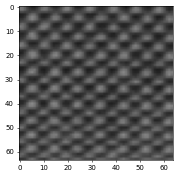

tf.Tensor(
[[[119. 119. 119.]
  [113. 113. 113.]
  [ 93.  93.  93.]
  ...
  [ 45.  45.  45.]
  [ 39.  39.  39.]
  [ 39.  39.  39.]]

 [[118. 118. 118.]
  [116. 116. 116.]
  [ 96.  96.  96.]
  ...
  [ 47.  47.  47.]
  [ 37.  37.  37.]
  [ 43.  43.  43.]]

 [[ 73.  73.  73.]
  [ 73.  73.  73.]
  [ 66.  66.  66.]
  ...
  [ 68.  68.  68.]
  [ 57.  57.  57.]
  [ 64.  64.  64.]]

 ...

 [[ 98.  98.  98.]
  [103. 103. 103.]
  [ 87.  87.  87.]
  ...
  [ 83.  83.  83.]
  [ 77.  77.  77.]
  [ 76.  76.  76.]]

 [[ 98.  98.  98.]
  [ 85.  85.  85.]
  [ 75.  75.  75.]
  ...
  [ 59.  59.  59.]
  [ 55.  55.  55.]
  [ 60.  60.  60.]]

 [[ 53.  53.  53.]
  [ 52.  52.  52.]
  [ 58.  58.  58.]
  ...
  [ 82.  82.  82.]
  [ 91.  91.  91.]
  [ 91.  91.  91.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


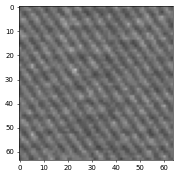

tf.Tensor(
[[[101. 101. 101.]
  [110. 110. 110.]
  [128. 128. 128.]
  ...
  [128. 128. 128.]
  [102. 102. 102.]
  [ 90.  90.  90.]]

 [[ 97.  97.  97.]
  [109. 109. 109.]
  [118. 118. 118.]
  ...
  [145. 145. 145.]
  [110. 110. 110.]
  [ 99.  99.  99.]]

 [[114. 114. 114.]
  [ 93.  93.  93.]
  [ 85.  85.  85.]
  ...
  [128. 128. 128.]
  [140. 140. 140.]
  [122. 122. 122.]]

 ...

 [[112. 112. 112.]
  [115. 115. 115.]
  [126. 126. 126.]
  ...
  [101. 101. 101.]
  [ 94.  94.  94.]
  [112. 112. 112.]]

 [[ 94.  94.  94.]
  [121. 121. 121.]
  [125. 125. 125.]
  ...
  [118. 118. 118.]
  [ 86.  86.  86.]
  [109. 109. 109.]]

 [[ 83.  83.  83.]
  [106. 106. 106.]
  [117. 117. 117.]
  ...
  [120. 120. 120.]
  [101. 101. 101.]
  [ 94.  94.  94.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


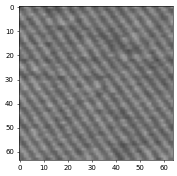

tf.Tensor(
[[[ 84.  84.  84.]
  [106. 106. 106.]
  [143. 143. 143.]
  ...
  [106. 106. 106.]
  [108. 108. 108.]
  [135. 135. 135.]]

 [[104. 104. 104.]
  [ 91.  91.  91.]
  [109. 109. 109.]
  ...
  [125. 125. 125.]
  [ 95.  95.  95.]
  [ 92.  92.  92.]]

 [[131. 131. 131.]
  [110. 110. 110.]
  [108. 108. 108.]
  ...
  [124. 124. 124.]
  [109. 109. 109.]
  [ 93.  93.  93.]]

 ...

 [[109. 109. 109.]
  [121. 121. 121.]
  [154. 154. 154.]
  ...
  [109. 109. 109.]
  [121. 121. 121.]
  [146. 146. 146.]]

 [[104. 104. 104.]
  [108. 108. 108.]
  [142. 142. 142.]
  ...
  [135. 135. 135.]
  [120. 120. 120.]
  [135. 135. 135.]]

 [[109. 109. 109.]
  [ 97.  97.  97.]
  [113. 113. 113.]
  ...
  [145. 145. 145.]
  [110. 110. 110.]
  [112. 112. 112.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


In [7]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi']     = 50

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(0, len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.show()
        print(images[i])
        print(labels[i])
        print("-----------------------------")
    

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid') # reports inflated acc and tiny loss values
#   layers.Dense(1)

])



In [10]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        3

In [11]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 23s 77ms/step - loss: 0.5298 - accuracy: 0.7449 - val_loss: 0.4067 - val_accuracy: 0.8066
Epoch 2/15
159/159 [==============================] - 11s 69ms/step - loss: 0.4659 - accuracy: 0.7686 - val_loss: 0.3567 - val_accuracy: 0.8087
Epoch 3/15
159/159 [==============================] - 12s 75ms/step - loss: 0.4170 - accuracy: 0.7715 - val_loss: 0.3793 - val_accuracy: 0.7756
Epoch 4/15
159/159 [==============================] - 11s 69ms/step - loss: 0.3988 - accuracy: 0.7846 - val_loss: 0.3249 - val_accuracy: 0.8004
Epoch 5/15
159/159 [==============================] - 10s 64ms/step - loss: 0.3499 - accuracy: 0.8290 - val_loss: 0.2260 - val_accuracy: 0.9162
Epoch 6/15
159/159 [==============================] - 11s 72ms/step - loss: 0.2608 - accuracy: 0.8896 - val_loss: 0.1459 - val_accuracy: 0.9462
Epoch 7/15
159/159 [==============================] - 11s 71ms/step - loss: 0.1815 - accuracy: 0.9285 - val_loss: 0.1123 - val_accuracy:

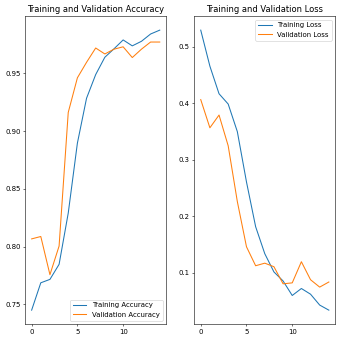

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 2s 56ms/step - loss: 0.1051 - accuracy: 0.9699


{'loss': 0.10506768524646759, 'accuracy': 0.9698581695556641}

In [14]:
# cwd = os.getcwd()
model.save("inspection_model")

#model.save_weights("inspection_weights")

INFO:tensorflow:Assets written to: inspection_model\assets


In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [17]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

In [18]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 13s 74ms/step - loss: 0.5344 - accuracy: 0.7445 - val_loss: 0.3972 - val_accuracy: 0.7808
Epoch 2/15
159/159 [==============================] - 11s 70ms/step - loss: 0.4802 - accuracy: 0.7688 - val_loss: 0.4115 - val_accuracy: 0.7756
Epoch 3/15
159/159 [==============================] - 11s 71ms/step - loss: 0.4446 - accuracy: 0.7680 - val_loss: 0.3490 - val_accuracy: 0.7797
Epoch 4/15
159/159 [==============================] - 11s 67ms/step - loss: 0.3948 - accuracy: 0.7828 - val_loss: 0.3423 - val_accuracy: 0.7983
Epoch 5/15
159/159 [==============================] - 10s 66ms/step - loss: 0.3290 - accuracy: 0.8450 - val_loss: 0.3990 - val_accuracy: 0.7725
Epoch 6/15
159/159 [==============================] - 11s 69ms/step - loss: 0.2652 - accuracy: 0.8965 - val_loss: 0.1647 - val_accuracy: 0.9493
Epoch 7/15
159/159 [==============================] - 11s 67ms/step - loss: 0.1706 - accuracy: 0.9354 - val_loss: 0.1620 - val_accuracy:

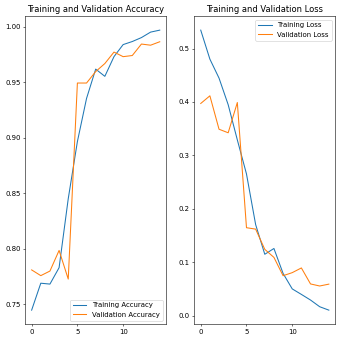

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save("inspection_model_aug")


INFO:tensorflow:Assets written to: inspection_model_aug\assets


In [21]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 1s 31ms/step - loss: 0.0573 - accuracy: 0.9876


{'loss': 0.05731026083230972, 'accuracy': 0.98758864402771}

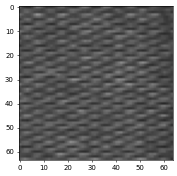

CNN output: [[0.0570302]]
This image most likely belongs to defect with a 94.30 percent confidence.
inference took: 0.10624849982559681 ms


In [25]:
path = "./test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)
print("inference took:", timeTaken,"ms")

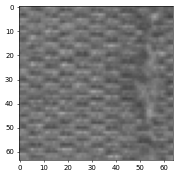

CNN output: [[0.00102955]]
This image most likely belongs to defect with a 99.90 percent confidence.
inference took: 0.04967499990016222 ms


In [27]:
path = "./test_data/defect/defect_1.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

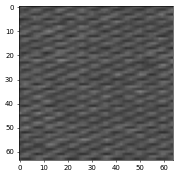

CNN output: [[0.9953567]]
This image most likely belongs to normal with a 99.54 percent confidence.
inference took: 0.06951729999855161 ms


In [29]:
path = "./test_data/normal/normal_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

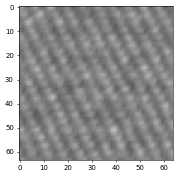

CNN output: [[0.9999994]]
This image most likely belongs to normal with a 100.00 percent confidence.
inference took: 0.0671560000628233 ms


In [30]:
path = "./test_data/normal/normal_1.png"


cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [31]:
# dad got an accarcy of 93% on inspections machines without ai

In [32]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


In [33]:

result = reconstructed_model.evaluate(test_ds)

dict(zip(reconstructed_model.metrics_names, result))

18/18 [==============================] - 1s 20ms/step - loss: 0.1051 - accuracy: 0.9699


{'loss': 0.1050676703453064, 'accuracy': 0.9698581695556641}

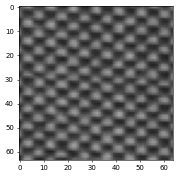

CNN output: [[0.00076872]]
This image most likely belongs to defect with a 99.92 percent confidence.
inference took: 0.13949669990688562 ms


In [34]:
path = "./test_data/defect/defect_20.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

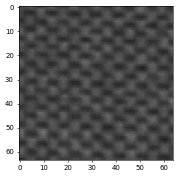

CNN output: [[0.9974143]]
This image most likely belongs to normal with a 99.74 percent confidence.
inference took: 0.049715999979525805 ms


In [35]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

Have to change batchsize to properly inspect, not needed if data isnt shuffled

In [36]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [37]:
model = reconstructed_model

preds = model.predict(test_ds,batch_size = 1,
verbose=1)

individualPredicts = []

TP = 0
TN = 0
FP = 0
FN = 0

names = os.listdir("./test_data/defect/")
for name in names:
    path = "./test_data/defect/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 0:
        TP = TP + 1
    else:
        FP = FP + 1
        
    
    
    
names = os.listdir("./test_data/normal/")
for name in names:
    path = "./test_data/normal/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 1:
        TN = TN + 1
    else:
        FN = FN + 1


# print(preds)
# print(individualPredicts)
print(TP, FP)
print(FN, TN)



564/564 [==============================] - 2s 3ms/step
86 2
15 461


In [38]:
predictions = []
targets  = []

start = time.perf_counter()

for image, target in test_ds:
    prediction = model.predict(image)
    targets.append(tf.get_static_value(target)[0][0])
    predictions.append(int(np.rint(prediction[0])))
    
taken = time.perf_counter() - start

print("time using single prediction:", taken)



time using single prediction: 36.79014839977026


[[ 86   2]
 [ 15 461]]


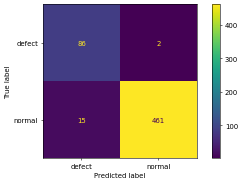

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()



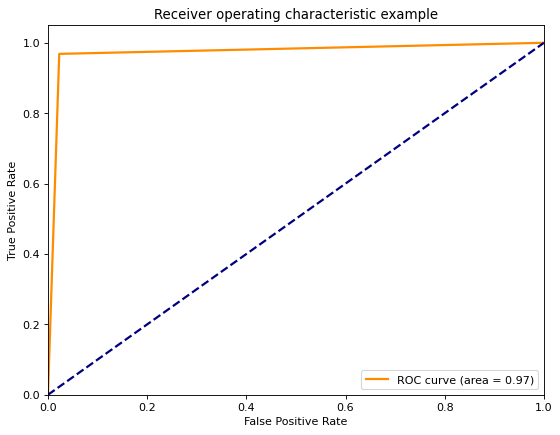

In [40]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, _ = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [41]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91        88
         1.0       1.00      0.97      0.98       476

    accuracy                           0.97       564
   macro avg       0.92      0.97      0.95       564
weighted avg       0.97      0.97      0.97       564



In [42]:

result = reconstructed_model.evaluate(all_ds)

dict(zip(reconstructed_model.metrics_names, result))

3570/3570 [==============================] - 301s 84ms/step - loss: 0.0682 - accuracy: 0.9796


{'loss': 0.06819064915180206, 'accuracy': 0.9795825481414795}

In [43]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 114216 files belonging to 2 classes.


In [59]:
predictions = reconstructed_model.predict(all_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

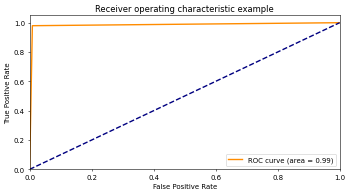

In [60]:
targets = np.concatenate([targets for features, targets in all_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[   901      8]
 [  2324 110983]]
2.0510648062343897


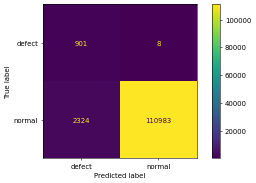

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

# With confidence 0.05 cutoff

In [62]:
predictions = reconstructed_model.predict(all_ds)

print("predictions done")



predictions done


In [63]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.02:
        p_temp = 1
    roundedPredictions.append(p_temp)

[[   858     51]
 [   430 112877]]
0.3794999426337296


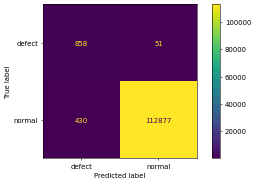

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
disp.plot()
plt.show()

shuffel Off

In [50]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 564 files belonging to 2 classes.


In [51]:

start = time.perf_counter()
predictions = reconstructed_model.predict(test_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))
    
taken = time.perf_counter() - start

print("time taken using batch prediction:", taken)


time taken using batch prediction: 0.7223322000354528


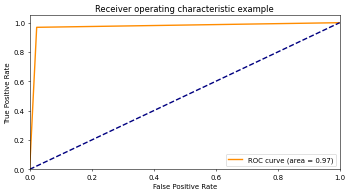

In [52]:
targets = np.concatenate([targets for features, targets in test_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[ 86   2]
 [ 15 461]]


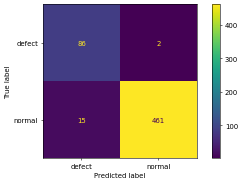

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

Checking opencv conversion

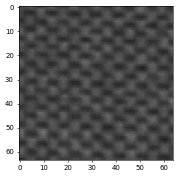

CNN output: [[0.9974143]]
This image most likely belongs to normal with a 99.74 percent confidence.
TensorFlow image prediction:  0.9974143
OpenCv image prediction:  0.9974143


In [54]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])

